# Gamma-Gamma Model of Monetary Value in PyMC

In this notebook we describe how to fit Fader's and Hardie's *gamma-gamma model* presented in the paper ["RFM and CLV: Using Iso-value Curves
for Customer Base Analysis"](http://www.brucehardie.com/papers/rfm_clv_2005-02-16.pdf) and the note ["The Gamma-Gamma Model of Monetary
Value"](http://www.brucehardie.com/notes/025/gamma_gamma.pdf). The approach is very similar as the one presented in the previous post [BG/NBD Model in PyMC](https://juanitorduz.github.io/bg_nbd_pymc/) where we simply ported the log-likelihood of the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package from `numpy` to `theano`.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes import GammaGammaFitter
import pymc3 as pm
import theano.tensor as tt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

## Load Data

We are going to use an existing data set from the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package documentation, see [here](https://lifetimes.readthedocs.io/en/latest/Quickstart.html).

In [2]:
data_df = load_cdnow_summary_data_with_monetary_value()

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2357 entries, 1 to 2357
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       2357 non-null   int64  
 1   recency         2357 non-null   float64
 2   T               2357 non-null   float64
 3   monetary_value  2357 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 92.1 KB


From the package’s documentation:

- `frequency`: Number of repeat purchases the customer has made. More precisely, It’s the count of time periods the customer had a purchase in.
- `monetary_value`: represents the average value of a given customer’s purchases. 

LEt us plot the distribution of the features of interest:

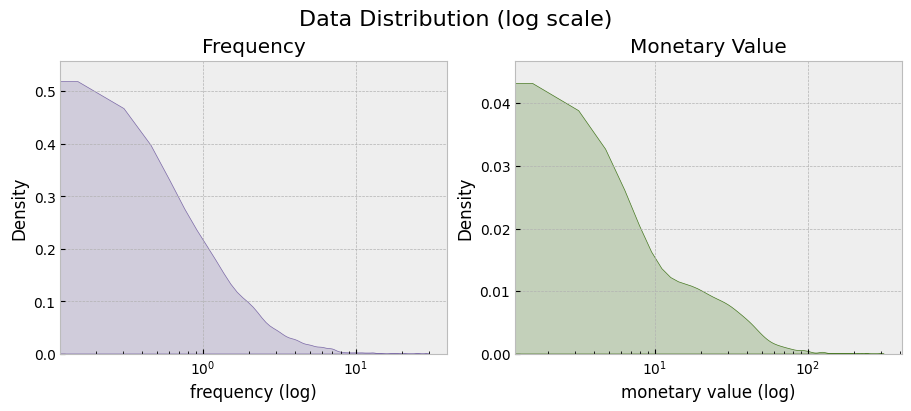

In [3]:


fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(9, 4),
    sharex=False,
    sharey=False,
    layout="constrained"
)
sns.kdeplot(x="frequency", data=data_df, color="C2", clip=(0.0, None), fill=True, ax=ax[0])
ax[0].set(title="Frequency",xlabel="frequency (log)",xscale="log")
sns.kdeplot(x="monetary_value", data=data_df, color="C3", clip=(0.0, None), fill=True, ax=ax[1])
ax[1].set(title="Monetary Value",xlabel="monetary value (log)",xscale="log")
fig.suptitle("Data Distribution (log scale)", fontsize=16);

## Gamma-Gamma Model (Lifetimes)

In this first section we we fit the model using the [`GammaGammaFitter`](https://lifetimes.readthedocs.io/en/latest/lifetimes.fitters.html#module-lifetimes.fitters.gamma_gamma_fitter) class from the [`lifetimes`](https://lifetimes.readthedocs.io/en/latest/) package. Before fitting the model, let us recall the model specification (see ["The Gamma-Gamma Model of Monetary
Value"](http://www.brucehardie.com/notes/025/gamma_gamma.pdf)). First, here are the assumptions:

> - The monetary value of a customer’s given transaction varies randomly around their average transaction value.
> - Average transaction values vary across customers but do not vary over time for any given individual.
> - The distribution of average transaction values across customers is independent of the transaction process.

Let $\bar{z}$ be the observed average transaction value for a given customer. One is generally interested in the expected value $E(Z|\bar{z}, x)$, where $Z$ denotes the random variable of the customer monetary value per transaction and $x$ is the observed frequency (see last section below). Now let us look into the concrete model parametrization:

> - We assume that $z_i \sim \text{Gamma}(p, \nu)$, with $E(Z_i| p, \nu) = \xi = p/\nu$.
>   - Given the convolution properties of the gamma, it follows that total spend across $x$ transactions is distributed $\text{Gamma}(px, \nu)$.
>   - Given the scaling property of the gamma distribution, it follows $\bar{z} \sim \text{Gamma}(px, νx)$.
> -  We assume $\nu \sim \text{Gamma}(q, \gamma)$.

**Remark:** The notation used in the paper is slightly different from the one used in the [`lifetimes`](https://lifetimes.readthedocs.io/en/latest/) package. The parameter $\gamma$ is denoted by $v$.

For more details in the theory and the consequences of this parametrization please see the references above.

When fitting the model, we need to be careful with two conditions:

1. We must remove users without repeated purchases.
2. The Gamma-Gamma model assumes that there is no relationship between the monetary value and the purchase frequency.

For the first condition we simply filter out the data:

In [4]:
data_df.query("frequency > 0", inplace=True)

For the second condition we compute the correlation:

In [5]:
data_df.filter(["frequency", "monetary_value"]).corr()

,frequency,monetary_value
frequency,1.000000,0.113884
monetary_value,0.113884,1.000000


The correlation is not very high. Let us see it ins a scatter plot:

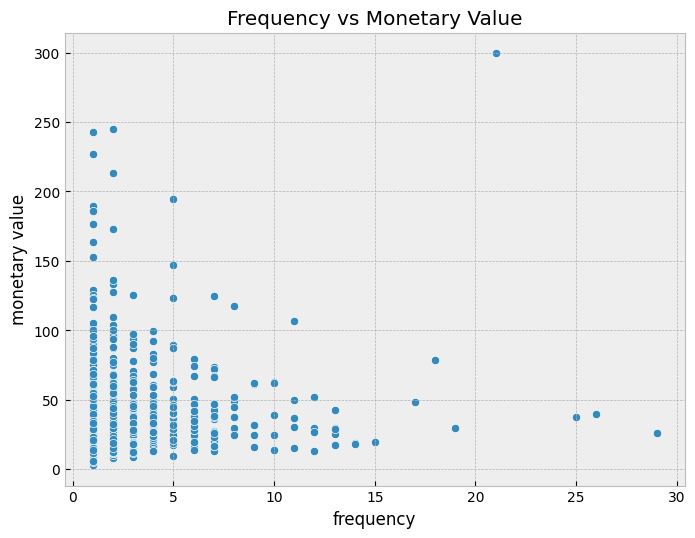

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(x="frequency", y="monetary_value", data=data_df, ax=ax)
ax.set(title="Frequency vs Monetary Value",xlabel="frequency",ylabel="monetary value");

There does not seem to be a high relation between these features, so we can move and fir the `lifetimes` model.

In [7]:
# extract the data using the paper's (and lifetimes) notation 
x = data_df["frequency"].to_numpy()
m = data_df["monetary_value"].to_numpy()

In [8]:
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(frequency=x, monetary_value=m)

ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.248802,1.189687,3.917016,8.580589
q,3.744588,0.290166,3.175864,4.313313
v,15.447748,4.159994,7.294160,23.601336


These errors are computed using the Hessian (see for example [here](http://www.sherrytowers.com/mle_introduction.pdf)).

## Bayesian Model

We use the same strategy of the post [BG/NBD Model in PyMC](https://juanitorduz.github.io/bg_nbd_pymc/) where we rewrite the log-likelihood of the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package from `numpy` to `theano`. In this case the expression is much simpler, see the `staticmethod` of the class `GammaGammaFitter._negative_log_likelihood`.

In [9]:
with pm.Model() as model:

    p = pm.HalfNormal(name="p", sd=10)
    q = pm.HalfNormal(name="q", sd=10)
    v = pm.HalfNormal(name="v", sd=10)

    def logp(x, m):
        return (
            tt.gammaln(p * x + q)
            - tt.gammaln(p * x)
            - tt.gammaln(q)
            + q * tt.log(v)
            + (p * x - 1) * tt.log(m)
            + (p * x) * tt.log(x)
            - (p * x + q) * tt.log(x * m + v)
        )
    
    likelihood = pm.DensityDist(
        name="likelihood",
        logp=logp,
        observed = {"x":x, "m": m}
    )

Next, we estimate the posterior distribution.

In [10]:
with model:
    trace = pm.sample(
        tune=2000,
        draws=6000,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, q, p]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 88 seconds.
The number of effective samples is smaller than 25% for some parameters.


Let us take a look at the model summary:

In [11]:
az.summary(data=trace, var_names=["p", "q", "v"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.967,1.361,4.709,9.493,0.019,0.014,5240.0,6051.0,1.0
q,3.668,0.264,3.174,4.167,0.004,0.002,5630.0,6862.0,1.0
v,14.095,3.490,7.846,20.807,0.050,0.035,4835.0,5664.0,1.0


We now plot the posterior distributions and compare them against the point estimate of the `GammaFitter` model.

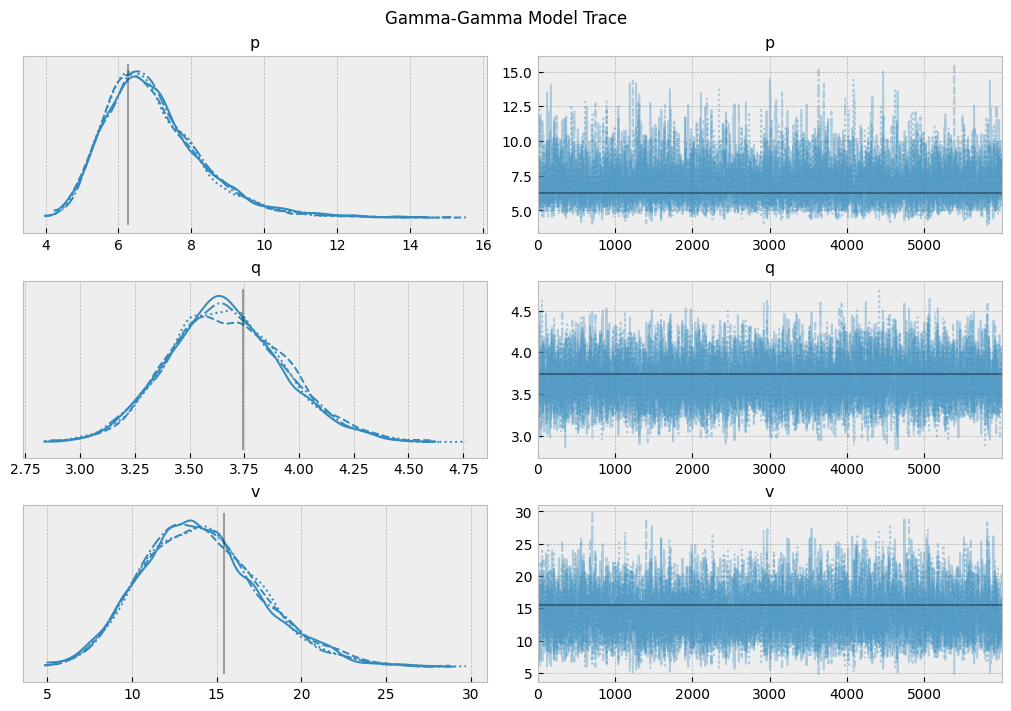

In [12]:
axes = az.plot_trace(
    data=trace,
    lines=[(k, {}, [v]) for k, v in ggf.summary["coef"].items()],
    compact=True,
    backend_kwargs={
        "figsize": (10, 7),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Gamma-Gamma Model Trace");

The results look comparable!

Finally, let's look into the pair-plot of the posterior distributions: 

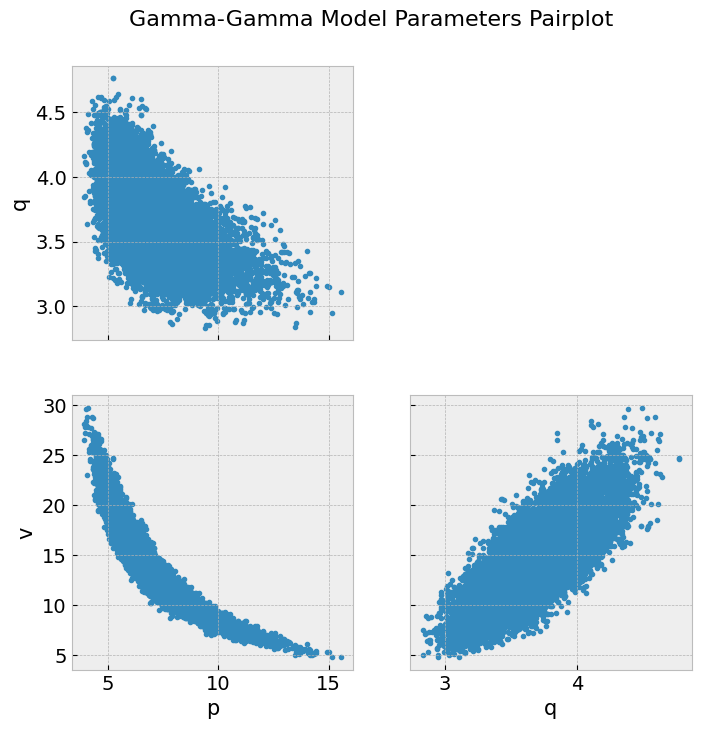

In [13]:
axes = az.plot_pair(data=trace, var_names=["p", "q", "v"], figsize=(8, 8))
fig = plt.gcf()
fig.suptitle("Gamma-Gamma Model Parameters Pairplot", y=0.95, fontsize=16);

It is interesting to see that the `p` and `v` distributions seem to obey a non-linear relationship.

## Conditional Expected Average Profit

Now that we have posterior samples at our disposal, we can compute quantities of interest using the expressions from the `lifetimes` package (and the papers of course). For example, let us compute the *conditional expected average profit* defined by the expected value $E(Z|\bar{z}, x)$. One can show that the expected average profit is a weighted average of individual monetary value and the population mean (see Equation 5 in  ["The Gamma-Gamma Model of Monetary
Value"](http://www.brucehardie.com/notes/025/gamma_gamma.pdf)).

First we compute it using the method `GammaGammaFitter.conditional_expected_average_profit`:

In [14]:
ggf_ceap = ggf.conditional_expected_average_profit(frequency=x, monetary_value=m)

Next, we compare it to the results from the `pymc` model. We do this by simply re-writing (specifically, vectorizing) the method above.

In [15]:
# https://docs.pymc.io/en/stable/pymc-examples/examples/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html
def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement."""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]

def conditional_expected_average_profit(trace, x, m, n_samples):
    posterior = trace.posterior.stack(sample=('chain', 'draw'))
    p = _sample(array=posterior["p"], n_samples=n_samples).to_numpy()[..., None]
    q = _sample(array=posterior["q"], n_samples=n_samples).to_numpy()[..., None]
    v = _sample(array=posterior["v"], n_samples=n_samples).to_numpy()[..., None]

    individual_weight = p * x[None, ...] / (p * x[None, ...] + q - 1)
    population_mean = (v * p) / (q - 1)
    return (population_mean * (1 - individual_weight)) + (individual_weight * m)


n_samples = 1000

pymc_ceap = conditional_expected_average_profit(trace, x, m, n_samples)

Finally, we can compare the results:

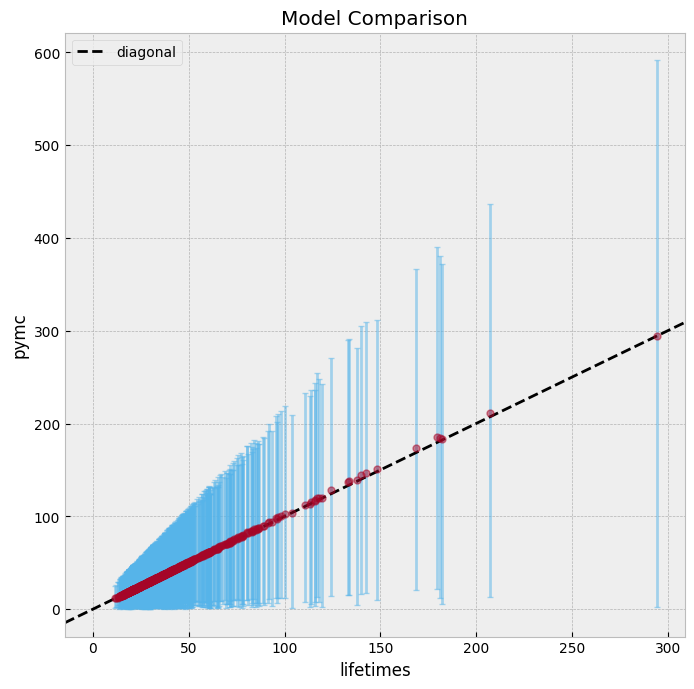

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.errorbar(
    x=ggf_ceap,
    y=pymc_ceap.mean(axis=0),
    yerr=az.hdi(ary=pymc_ceap).T,
    fmt="o",
    ecolor="C6",
    markeredgecolor="C1",
    markerfacecolor="C1",
    markersize=5,
    alpha=0.5,
    capsize=2,
)
ax.axline(
    xy1=(0, 0),
    slope=1,
    color="black",
    linestyle="--",
    label="diagonal"
)
ax.legend(loc="upper left")
ax.set(title="Model Comparison", xlabel="lifetimes", ylabel="pymc");

Note that the credible intervals increase as the monetary value increases. This is no surprise given the data distribution (see first plot above).

**Remark:** Note that the credible intervals are always positive:

In [17]:
assert az.hdi(ary=pymc_ceap).min().min() > 0